# Julia is fast

Very often, benchmarks are used to compare languages. These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences. These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: [https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb]().)


## Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
  - C (hand-written)
  - C (hand-written with -ffast-math)
  - python (built-in)
  - python (numpy)
  - python (hand-written)
  - Julia (built-in)
  - Julia (hand-written)
  - Julia (hand-written with SIMD)
- Summary of benchmarks

## sum: An easy enough function to understand
Consider the sum function `sum(a)`, which computes
$$
\mathrm{sum}(a)=\sum_{i=1}^n a_i,
$$
where $n$ is the length of $a$.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.5572547741976575  
 0.8727587760129973  
 0.49135866994457666 
 0.18123640187643808 
 0.9842497443406053  
 0.7871596730785038  
 0.009559893231301464
 0.8797176995464948  
 0.23309869655557325 
 0.3203871792935873  
 0.19771756820115294 
 0.7801730719895528  
 0.40104042765277903 
 ⋮                   
 0.4679552427667941  
 0.3257853208748085  
 0.4853154867365139  
 0.6918817876938064  
 0.9142010238654066  
 0.24684095578115972 
 0.9879337991000432  
 0.8085902797817175  
 0.8267102661248351  
 0.375441808884325   
 0.6088728107280998  
 0.4181674800261439  

In [2]:
sum(a)

4.998061185374489e6

The expected result is `0.5 * 10^7`, since the mean of each entry is `0.5`.

## Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.003749 seconds (5 allocations: 176 bytes)


4.998061185374489e6

In [4]:
@time sum(a)

  0.003532 seconds (5 allocations: 176 bytes)


4.998061185374489e6

In [5]:
@time sum(a)

  0.003743 seconds (5 allocations: 176 bytes)


4.998061185374489e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using BenchmarkTools

### The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [7]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib      = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -mavx2 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [8]:
@show c_sum(a)

c_sum(a) = 4.998061185374056e6


4.998061185374056e6

In [9]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [10]:
c_sum(a) - sum(a)

-4.330649971961975e-7

In [11]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

#### Examples

In [12]:
0.1 ≈ (0.1 - 1e-10)

true

In [13]:
isapprox(10, 11; atol = 2)

true

In [14]:
isapprox([10.0^9, 1.0], [10.0^9, 2.0])

true

In [15]:
1e-10 ≈ 0

false

In [16]:
isapprox(1e-10, 0, atol=1e-8)

true

We can now benchmark the C code directly from Julia:

In [17]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.555 ms (0.00% GC)
  median time:      9.872 ms (0.00% GC)
  mean time:        10.204 ms (0.00% GC)
  maximum time:     14.675 ms (0.00% GC)
  --------------
  samples:          490
  evals/sample:     1

We'll collect all the results in a dictionary

In [18]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 9.555

It's worth noting that benchmarking on a computer can be tricky as can been seen
from a histogram of the timings

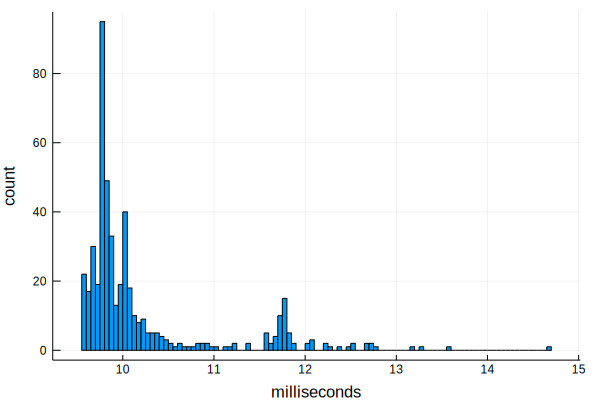

In [19]:
using Plots
histogram(c_bench.times/1000^2, bins=100,
    xlabel="milliseconds", ylabel="count", label="")

### C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -march=native -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.079 ms (0.00% GC)
  median time:      5.006 ms (0.00% GC)
  mean time:        5.003 ms (0.00% GC)
  maximum time:     8.890 ms (0.00% GC)
  --------------
  samples:          998
  evals/sample:     1

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.078704

### Python's built in sum
The `PyCall` package provides a Julia interface to Python:

In [23]:
# using Pkg; Pkg.add("PyCall")
using PyCall

We can create a Julia function which points to the Python built-in "sum" function:

In [24]:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     632.694 ms (0.00% GC)
  median time:      637.748 ms (0.00% GC)
  mean time:        645.748 ms (0.00% GC)
  maximum time:     702.217 ms (0.00% GC)
  --------------
  samples:          8
  evals/sample:     1

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 9.555
  "Python built-in" => 632.694
  "C -ffast-math"   => 4.0787

### Python: numpy

Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python. It may be installed within Julia as follows:

In [28]:
# using Pkg; Pkg.add("Conda")
using Conda
# Conda.add("numpy")

In [29]:
numpy_sum = pyimport("numpy").sum

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     3.240 ms (0.00% GC)
  median time:      4.018 ms (0.00% GC)
  mean time:        4.280 ms (0.00% GC)
  maximum time:     11.782 ms (0.00% GC)
  --------------
  samples:          1166
  evals/sample:     1

In [30]:
numpy_sum(a) ≈ sum(a)

true

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 9.555
  "Python numpy"    => 3.2401
  "Python built-in" => 632.694
  "C -ffast-math"   => 4.0787

### Python, hand-written

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x1243c8840>

In [33]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     777.727 ms (0.00% GC)
  median time:      790.730 ms (0.00% GC)
  mean time:        808.142 ms (0.00% GC)
  maximum time:     894.651 ms (0.00% GC)
  --------------
  samples:          7
  evals/sample:     1

In [34]:
sum_py(a) ≈ sum(a)

true

In [35]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 9.555
  "Python numpy"        => 3.2401
  "Python hand-written" => 777.727
  "Python built-in"     => 632.694
  "C -ffast-math"       => 4.0787

### R (built-in)

In [36]:
using RCall
sum_R(a) = R"sum($a)"

sum_R (generic function with 1 method)

In [37]:
r_bench = @benchmark $sum_R($a)

BenchmarkTools.Trial: 
  memory estimate:  3.13 KiB
  allocs estimate:  104
  --------------
  minimum time:     43.579 ms (0.00% GC)
  median time:      45.773 ms (0.00% GC)
  mean time:        46.723 ms (0.00% GC)
  maximum time:     55.652 ms (0.00% GC)
  --------------
  samples:          108
  evals/sample:     1

In [38]:
d["R built-in"] = minimum(r_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 9.555
  "Python numpy"        => 3.2401
  "Python hand-written" => 777.727
  "Python built-in"     => 632.694
  "C -ffast-math"       => 4.0787
  "R built-in"          => 43.579

### R (hand-written)

In [39]:
mysum_R(a) = R"""
mysum <- function(a) {
  s = 0.0
  for (i in 1:length(a)) {
    s = s + a[i]
  }
  return(s)
}
mysum($a)
"""

mysum_R (generic function with 1 method)

In [40]:
r_hand_bench = @benchmark $mysum_R($a)

BenchmarkTools.Trial: 
  memory estimate:  3.25 KiB
  allocs estimate:  111
  --------------
  minimum time:     364.564 ms (0.00% GC)
  median time:      373.827 ms (0.00% GC)
  mean time:        375.718 ms (0.00% GC)
  maximum time:     391.130 ms (0.00% GC)
  --------------
  samples:          14
  evals/sample:     1

In [41]:
d["R hand-written"] = minimum(r_hand_bench.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "R hand-written"      => 364.564
  "C"                   => 9.555
  "Python numpy"        => 3.2401
  "Python hand-written" => 777.727
  "Python built-in"     => 632.694
  "C -ffast-math"       => 4.0787
  "R built-in"          => 43.579

### Julia (built-in)

Written directly in Julia, not in C!

In [42]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:648

In [43]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.027 ms (0.00% GC)
  median time:      4.701 ms (0.00% GC)
  mean time:        4.665 ms (0.00% GC)
  maximum time:     8.168 ms (0.00% GC)
  --------------
  samples:          1070
  evals/sample:     1

In [44]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "R hand-written"      => 364.564
  "C"                   => 9.555
  "Python numpy"        => 3.2401
  "Python hand-written" => 777.727
  "Python built-in"     => 632.694
  "Julia built-in"      => 4.02666
  "C -ffast-math"       => 4.0787
  "R built-in"          => 43.579

### Julia (hand-written)

In [45]:
function mysum(A)
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [46]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.042 ms (0.00% GC)
  median time:      12.020 ms (0.00% GC)
  mean time:        12.498 ms (0.00% GC)
  maximum time:     18.754 ms (0.00% GC)
  --------------
  samples:          400
  evals/sample:     1

In [47]:
mysum(a) ≈ sum(a)

true

In [48]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 9 entries:
  "R hand-written"      => 364.564
  "C"                   => 9.555
  "Python numpy"        => 3.2401
  "Julia hand-written"  => 10.0422
  "Python hand-written" => 777.727
  "Python built-in"     => 632.694
  "Julia built-in"      => 4.02666
  "C -ffast-math"       => 4.0787
  "R built-in"          => 43.579

### Julia (hand-written w. simd)

In [49]:
function mysum_simd(A)
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [50]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.049 ms (0.00% GC)
  median time:      4.951 ms (0.00% GC)
  mean time:        4.973 ms (0.00% GC)
  maximum time:     9.380 ms (0.00% GC)
  --------------
  samples:          1003
  evals/sample:     1

In [51]:
mysum_simd(a) ≈ sum(a)

true

In [52]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 10 entries:
  "Julia hand-written simd" => 4.04947
  "R hand-written"          => 364.564
  "C"                       => 9.555
  "Python numpy"            => 3.2401
  "Julia hand-written"      => 10.0422
  "Python hand-written"     => 777.727
  "Python built-in"         => 632.694
  "Julia built-in"          => 4.02666
  "C -ffast-math"           => 4.0787
  "R built-in"              => 43.579

## Summary

In [53]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................3.2
Julia built-in..............4.0
Julia hand-written simd.....4.0
C -ffast-math...............4.1
C...........................9.6
Julia hand-written.........10.0
R built-in.................43.6
R hand-written............364.6
Python built-in...........632.7
Python hand-written.......777.7
